# Q2 
## Goal = Feature Importance

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from pylab import rcParams 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import normal_ad

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15,10

## _1. Import data_

In [3]:
fileLoc = 'C:/Users/lco73/Desktop/PreScreen_r3/palm_ffb.csv'
df = pd.read_csv(fileLoc, parse_dates=['Date'],index_col='Date',dayfirst=True)
df.reset_index(inplace=True)
print("First 5 example of data")
df.head()

First 5 example of data


,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,2008-01-01,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,2008-02-01,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,2008-03-01,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,2008-04-01,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,2008-05-01,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [4]:
#Check for missing Values
print(df.isna().sum())

Date             0
SoilMoisture     0
Average_Temp     0
Min_Temp         0
Max_Temp         0
Precipitation    0
Working_days     0
HA_Harvested     0
FFB_Yield        0
dtype: int64


#### Note: FFB_Yield is the dependant variable while the rest are independant variable.

## _2. Statistical Summary_

In [5]:
#Statistical description
df.describe() 

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


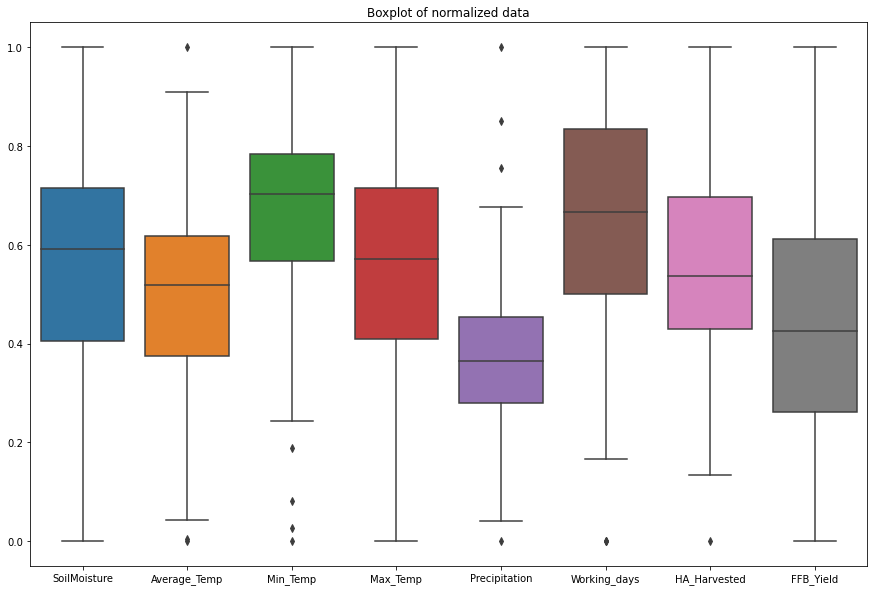

In [6]:
scaler = MinMaxScaler()
# standardize data
data_norm = pd.DataFrame(scaler.fit_transform(df.loc[:, df.columns != 'Date']),columns=list(df.loc[:, df.columns != 'Date'].columns))

sns.boxplot(data=data_norm)
plt.title('Boxplot of normalized data')
plt.show()

#### Findings:
#### 1. Outliers in temperature and precipitation variables are probably through natural variation. 
#### 2. Outliers from working_days and HA_harvested most probably not from data entry or measurement error since the min values are still within logical means

## _3. Data Analysis_

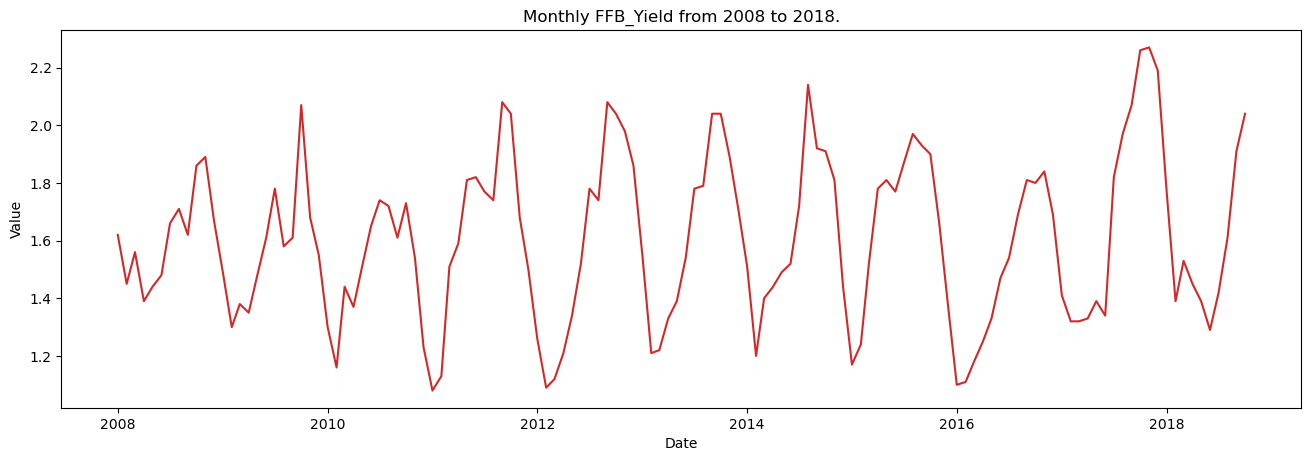

In [7]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Date, y=df.FFB_Yield, title='Monthly FFB_Yield from 2008 to 2018.')   

#### Findings: The figure above suggest this is a seasonal data with a particular pattern

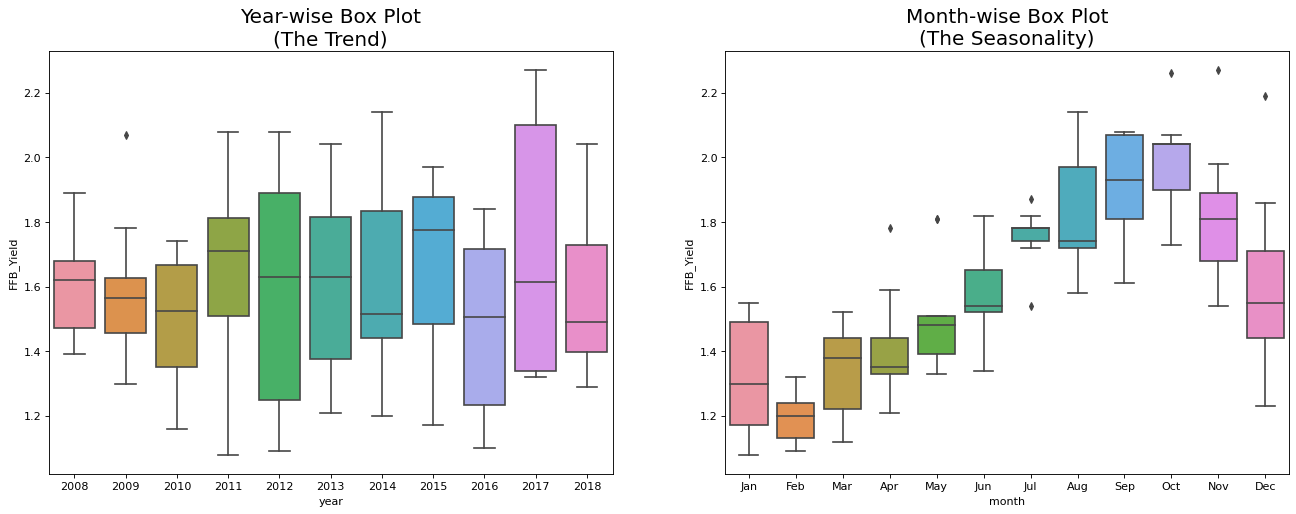

In [8]:
# Prepare data
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='FFB_Yield', data=df, ax=axes[0])
sns.boxplot(x='month', y='FFB_Yield', data=df.loc[~df.year.isin([2008, 2018]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

#### Findings: 
The boxplots above show that there is no significant trend in FFB_yield over the years but FFB_yield peak towards the end of third quarter of each year then gradually decreased in the fourth quarter.

## _4. Feature Importance_

### We will use 4 types of method to determine the feature importance scores:

1. Coefficients as Feature Importance

2. Decision Tree Feature Importance

3. Permutation Feature Importance

4. XGBoost Regression Feature Importance

### 1. Coefficients as Feature Importance - Multiple Linear Regression

#### There are 5 assumptions to test when doing multiple linear regression:
 a. Linearity (important for prediction but not for current objective)
 
 b. Normality of Error Terms (important for confidence interval but not for current objective)
 
 c. __No multicollinearity among independant variables (important for intepretation of coefficients, will be tested)__
 
 d. __Homoscedasticity (important for significant test for coefficients, will be tested)__
 
 e. No autocorrelation of the error terms (important for model estiamtes but not for current objective)

### *Check Multicollinearity

#### _Correlation analysis_

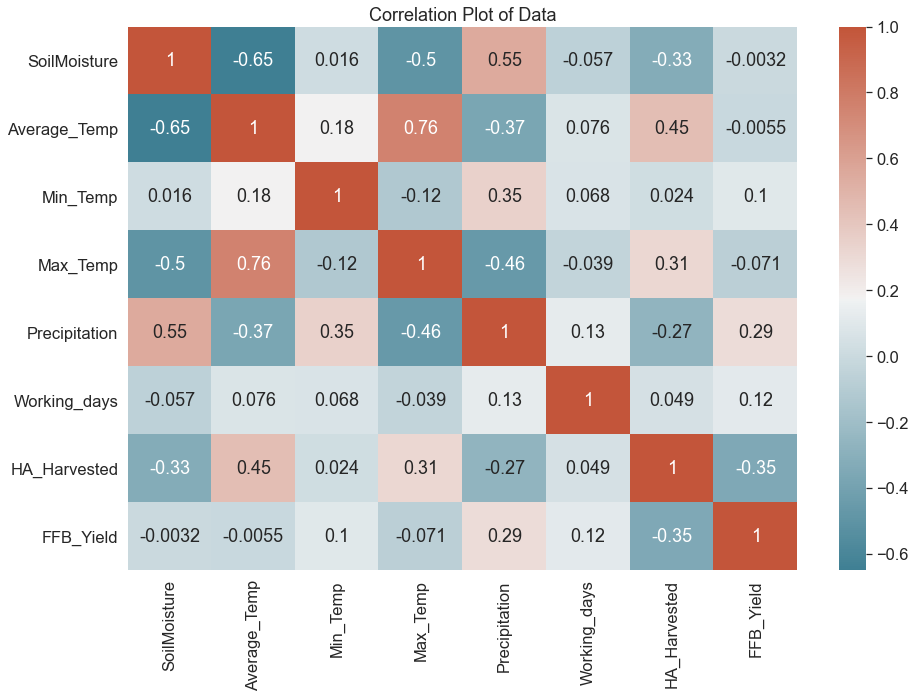

In [9]:
feature_names=['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested', 'FFB_Yield']
df2 = df[feature_names]
corr = df2.corr()
sns.set(font_scale=1.5) 
plt.subplots()
sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            annot=True, 
            cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Plot of Data')
plt.show()

#### Findings:
1. There is a positive correlation between FFB_yield and Precipitation
2. There is a negative correlation between FFB_yield and HA_Harvested
3. There is high negative correlation between SoilMoisture and Average_Temp/Precipitation
4. There is a very strong positive correlation between Average_Temp and Max_Temp
5. High correlations between independant variables indicate there are multi collinearity. Certain variables need to be dropped for multiple linear regression analysis. (note: in general, correlation value >0.7 is considered having high multicollinearity)

#### _Check Variation inflation factor (VIF)_

In [10]:
feature_names=['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested']
X=df[feature_names]
# the independent variables set
X_const = add_constant(X)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]
  
print(vif_data)

         feature          VIF
0          const  4796.616824
1   SoilMoisture     2.210236
2   Average_Temp     4.317216
3       Min_Temp     1.458334
4       Max_Temp     3.033652
5  Precipitation     1.887093
6   Working_days     1.058659
7   HA_Harvested     1.279879


#### Findings: 
1. Average_Temp has the highest VIF value and Max_Temp is the next highest.
2. We will drop one variable first and test VIF again to see if the rest of the VIF values decrease

In [11]:
# Dropping Average_Temp
# the independent variables set
X_const = X[['SoilMoisture', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested']] 
X_const = add_constant(X_const)
# VIF dataframe
 
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]
  
print(vif_data)

         feature          VIF
0          const  4046.846143
1   SoilMoisture     1.771125
2       Min_Temp     1.207380
3       Max_Temp     1.472426
4  Precipitation     1.881917
5   Working_days     1.046432
6   HA_Harvested     1.177792


In [12]:
# Dropping Average_Temp
model = smf.ols("FFB_Yield ~ SoilMoisture + Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm_2).fit()

model.summary()# Dropping Max_Temp
# the independent variables set
X_const = X[['SoilMoisture', 'Average_Temp', 'Min_Temp','Precipitation', 'Working_days', 'HA_Harvested']] 
X_const = add_constant(X_const)
# VIF dataframe
 
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                          for i in range(len(X_const.columns))]
  
print(vif_data)

         feature          VIF
0          const  4718.985168
1   SoilMoisture     2.172182
2   Average_Temp     2.095422
3       Min_Temp     1.300027
4  Precipitation     1.831582
5   Working_days     1.046895
6   HA_Harvested     1.269648


#### Findings:
1. Dropping the Average_Temp variable produces VIF values below 2 for all variables.
2. Although SoilMoisture and Precipitation are still higher than the rest of the variable, it is not too big of a difference, so we should consider dropping the Average_Temp variable if necessary since it is highly correlated to Max_Temp.

In [19]:
# Check Coefficients and statistical significance
model = smf.ols("FFB_Yield ~ SoilMoisture + Average_Temp + Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.935
Date:                Thu, 27 May 2021   Prob (F-statistic):           5.92e-06
Time:                        21:53:20   Log-Likelihood:                 22.379
No. Observations:                 130   AIC:                            -28.76
Df Residuals:                     122   BIC:                            -5.819
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5821      0.150      3.873      0.000       0.285       0.880
SoilMoisture     -0.2477      0.128     -1.937      0.055      -0.501       0.005
Average_Temp      0.2626      0.202      1.300      0.196      -0.137       0.663
Min_Temp         -0.0774      0.120     -0.644      0.521      -0.315       0.160
Max_Temp         -0.0533      0.146     -0.364      0.717      -0.343       0.236
Precipitation     0.5463      0.157      3.488      0.001       0.236       0.856
Working_days      0.0705      0.092      0.764      0.446      -0.112       0.253
HA_Harvested     -0.5526      0.121     -4.570      0.000      -0.792      -0.313
==============================================================================
Omnibus:                        0.930   Durbin-Watson:                   0.589
Prob(Omnibus):                  0.628   Jarque-Bera (JB):                1.042
Skew:                          -0.157   Prob(JB):                        0.594
Kurtosis:                       2.693   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Dropping Average_Temp and check statistical significance
model = smf.ols("FFB_Yield ~ SoilMoisture + Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     6.606
Date:                Thu, 27 May 2021   Prob (F-statistic):           4.50e-06
Time:                        21:53:24   Log-Likelihood:                 21.486
No. Observations:                 130   AIC:                            -28.97
Df Residuals:                     123   BIC:                            -8.899
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5962      0.150      3.966      0.000       0.299       0.894
SoilMoisture     -0.3218      0.115     -2.803      0.006      -0.549      -0.095
Min_Temp         -0.0126      0.110     -0.115      0.908      -0.230       0.204
Max_Temp          0.0832      0.102      0.814      0.417      -0.119       0.286
Precipitation     0.5570      0.157      3.551      0.001       0.247       0.867
Working_days      0.0833      0.092      0.906      0.366      -0.099       0.265
HA_Harvested     -0.5082      0.116     -4.370      0.000      -0.738      -0.278
==============================================================================
Omnibus:                        0.909   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.635   Jarque-Bera (JB):                1.009
Skew:                          -0.137   Prob(JB):                        0.604
Kurtosis:                       2.666   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Findings:
After dropping Average_Temp variable, the SoilMoisture Coefficient increased and is now statistically significant.

### *Check Homoscedasticity

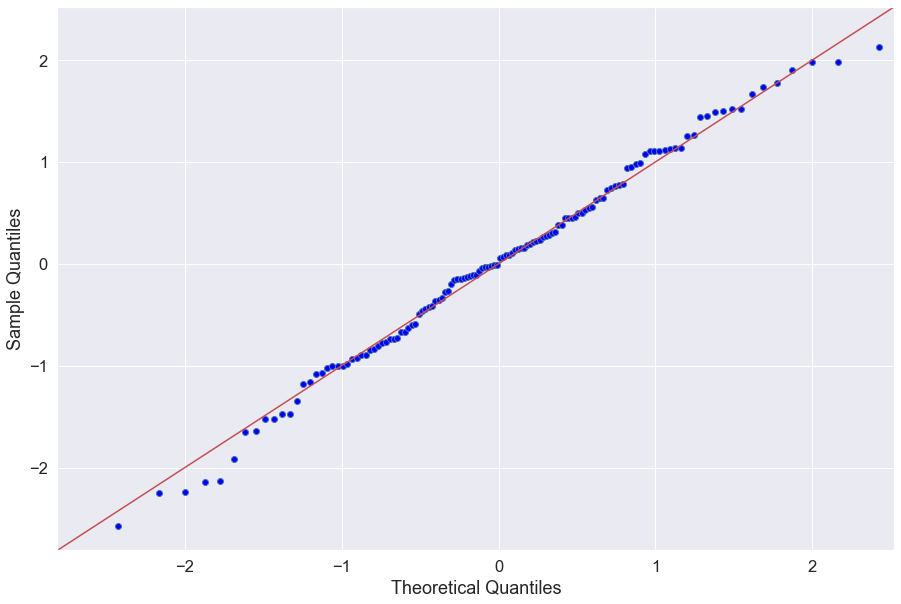

Breusch-Pagan Test and White LM Tests for Heteroscedasticity
             Test Type     Chi-Sq  DF  Prob>Chi-Sq
0  Koenkar-Basset Test  16.861756   2     0.018310
1           White Test  50.923826   4     0.040034


In [15]:
model = smf.ols("FFB_Yield ~ SoilMoisture + Average_Temp + Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm).fit()
# QQ-Plot of residuals
fig1 = sm.qqplot(model.resid,fit=True,line='45')
plt.show()

# Breusch-Pagan Test for Heteroscedasticity
bptest = sms.diagnostic.het_breuschpagan(model.resid,model.model.exog)
# White Test for Heteroscedasticity, including squares and cross-product of exog
white_test = sms.diagnostic.het_white(model.resid,model.model.exog)

print('Breusch-Pagan Test and White LM Tests for Heteroscedasticity')
df3 = pd.DataFrame({'Test Type':['Koenkar-Basset Test', 'White Test'],
                   'Chi-Sq':[bptest[0], white_test[0]], 'DF':[2, 4],
                   'Prob>Chi-Sq':[bptest[1], white_test[1]]})
print(df3)

#### Findings: 
p-value<0.05 therefore we reject the null hypothesis. There is heretoscedasticity in the data. 

In [22]:
#we will use Box-cox transformation give the data the aspect of a normal distribution

#setup data
feature_names=['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested', 'FFB_Yield']
X=df[feature_names]

#transform data
X_transformed = power_transform(X, method='box-cox')
data_trans = pd.DataFrame(X_transformed, columns=list(data_norm.columns))
scaler = MinMaxScaler()

# normalize data
data_norm_2 = pd.DataFrame(scaler.fit_transform(data_trans),columns=list(data_trans.columns))


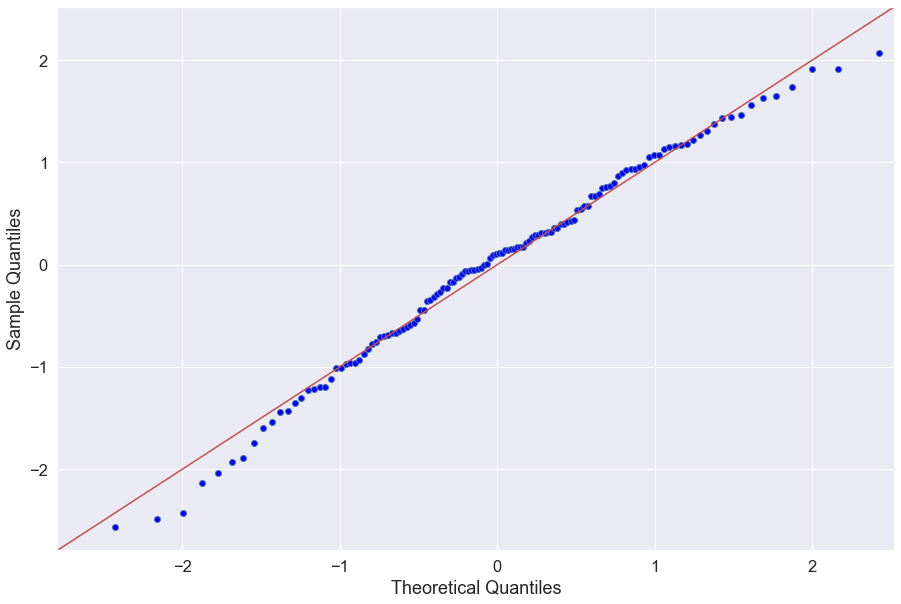

Breusch-Pagan Test and White LM Tests for Heteroscedasticity
             Test Type     Chi-Sq  DF  Prob>Chi-Sq
0  Koenkar-Basset Test  11.525393   2     0.117287
1           White Test  49.722795   4     0.050777


In [23]:
model = smf.ols("FFB_Yield ~ SoilMoisture +Average_Temp+ Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm_2).fit()
# QQ-Plot of residuals
fig1 = sm.qqplot(model.resid,fit=True,line='45')
plt.show()

# Breusch-Pagan Test for Heteroscedasticity
bptest = sms.diagnostic.het_breuschpagan(model.resid,model.model.exog)
# White Test for Heteroscedasticity, including squares and cross-product of exog
white_test = sms.diagnostic.het_white(model.resid,model.model.exog)

print('Breusch-Pagan Test and White LM Tests for Heteroscedasticity')
df4 = pd.DataFrame({'Test Type':['Koenkar-Basset Test', 'White Test'],
                   'Chi-Sq':[bptest[0], white_test[0]], 'DF':[2, 4],
                   'Prob>Chi-Sq':[bptest[1], white_test[1]]})
print(df4)

#### Findings: 
p-value>0.05 therefore we accept the null hypothesis. There data is no longer heretoscedastic. 

In [17]:
#check coefficients and statistical significance of all variables
model = smf.ols("FFB_Yield ~ SoilMoisture +Average_Temp+ Min_Temp + Max_Temp + Precipitation + Working_days + HA_Harvested", 
                data= data_norm_2).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              FFB_Yield   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     7.118
Date:                Thu, 27 May 2021   Prob (F-statistic):           3.97e-07
Time:                        21:47:07   Log-Likelihood:                 24.469
No. Observations:                 130   AIC:                            -32.94
Df Residuals:                     122   BIC:                            -9.998
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6076      0.132      4.617      0.000       0.347       0.868
SoilMoisture     -0.3730      0.128     -2.922      0.004      -0.626      -0.120
Average_Temp      0.1891      0.207      0.915      0.362      -0.220       0.598
Min_Temp         -0.1367      0.109     -1.251      0.213      -0.353       0.080
Max_Temp         -0.0407      0.142     -0.287      0.775      -0.322       0.240
Precipitation     0.7120      0.159      4.482      0.000       0.398       1.026
Working_days      0.0366      0.086      0.428      0.670      -0.133       0.206
HA_Harvested     -0.5387      0.119     -4.533      0.000      -0.774      -0.303
==============================================================================
Omnibus:                        2.595   Durbin-Watson:                   0.647
Prob(Omnibus):                  0.273   Jarque-Bera (JB):                2.635
Skew:                          -0.323   Prob(JB):                        0.268
Kurtosis:                       2.739   Cond. No.                         22.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Findings:

1. There is a statistically signifcant positive correlation between FFB_yield and Precipitation
2. There is a statistically signifcant negative correlation between FFB_yield and HA_Harvested
3. There is a statistically signifcant negative correlation between FFB_yield and SoilMoisture without removal of Average_Temp



P/S: The Durbin-Watson test shows a value of 0.585 which indicates positive autocorrelation. This means that there are some information not captured from our seasonal time series data. Adding lags of the dependant and/or independant variable to the model should be considered if model is to be used for predictions

### 2. Decision Tree Feature Importance

Feature: SoilMoisture, Score: 0.11527
Feature: Average_Temp, Score: 0.15930
Feature: Min_Temp, Score: 0.05392
Feature: Max_Temp, Score: 0.07178
Feature: Precipitation, Score: 0.23437
Feature: Working_days, Score: 0.03051
Feature: HA_Harvested, Score: 0.33485


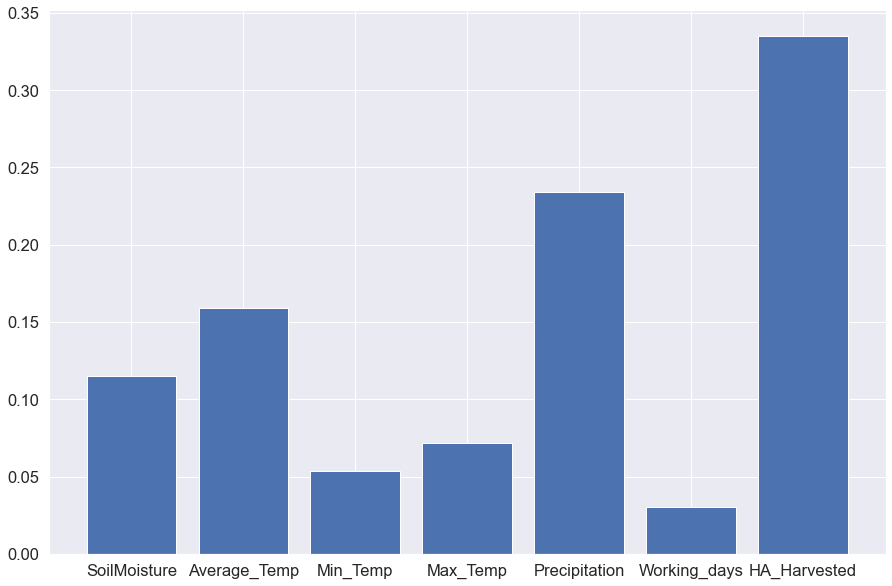

In [24]:
#setup data
feature_names=['SoilMoisture', 'Average_Temp', 'Min_Temp', 'Max_Temp', 'Precipitation', 'Working_days', 'HA_Harvested']

#use standardized data
X=data_norm_2[feature_names]
features=X.values
label=data_norm_2.FFB_Yield.values

# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestRegressor
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(features, label)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, tick_label=feature_names)
plt.show()

#### Findings:
1. HA_harvested rank the first in importance score
2. Precipitation rank the second in importance score
3. Average_Temp rank the thrird in importance score

### 3. Permutation Feature Importance

Feature: SoilMoisture, Score: 0.00579
Feature: Average_Temp, Score: 0.00362
Feature: Min_Temp, Score: 0.00289
Feature: Max_Temp, Score: 0.00562
Feature: Precipitation, Score: 0.00381
Feature: Working_days, Score: 0.00379
Feature: HA_Harvested, Score: 0.01351


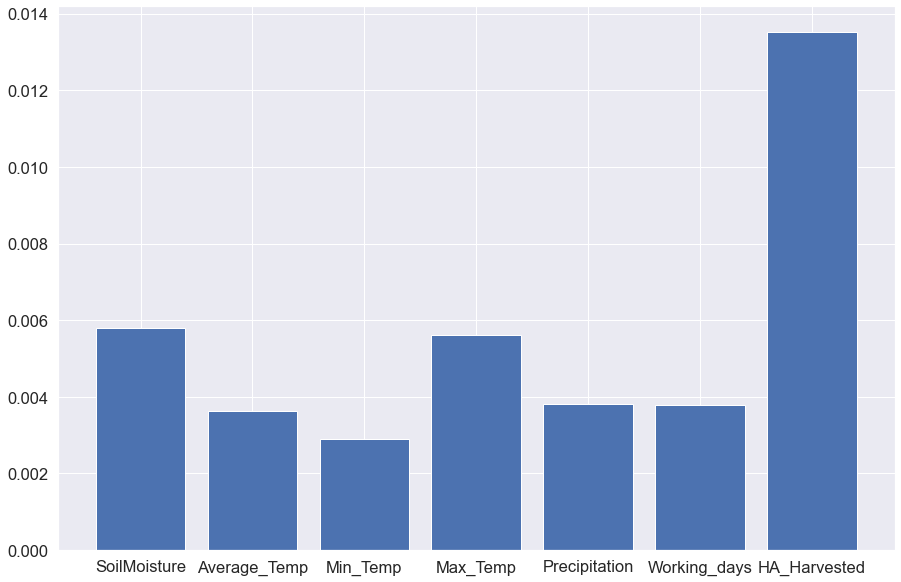

In [25]:
# permutation feature importance with knn for regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# define the model
model = KNeighborsRegressor()
# fit the model
model.fit(features, label)
# perform permutation importance
results = permutation_importance(model, features, label, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, tick_label=feature_names)
plt.show()

#### Findings:
1. HA_harvested rank the first in importance score
2. Max_Temp rank the second in importance score
3. Average_Temp rank the thrird in importance score

### 4. XGBoost Regression Feature Importance

Feature: SoilMoisture, Score: 0.06536
Feature: Average_Temp, Score: 0.12840
Feature: Min_Temp, Score: 0.12637
Feature: Max_Temp, Score: 0.06716
Feature: Precipitation, Score: 0.25021
Feature: Working_days, Score: 0.06555
Feature: HA_Harvested, Score: 0.29693


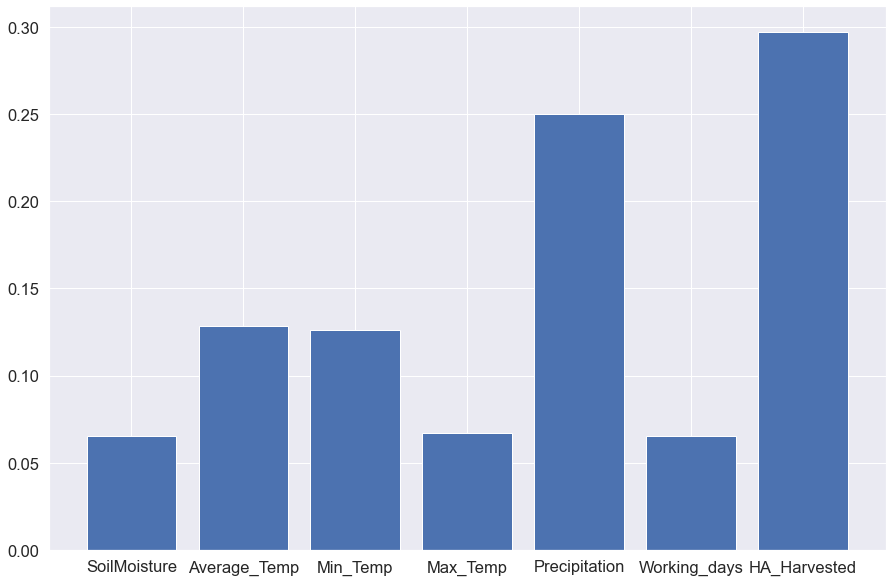

In [30]:
# xgboost for feature importance on a regression problem
from xgboost import XGBRegressor

# define the model
model = XGBRegressor()
# fit the model
model.fit(features, label)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %s, Score: %.5f' % (feature_names[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, tick_label=feature_names)
plt.show()

#### Findings:
1. HA_harvested rank the first in importance score
2. Precipitation rank the second in importance score
3. Average_Temp rank the thrird in importance score

# Conclusion

The most important variable is HA_harvested then comes Precipitation and SoilMoisture. Although, other feature importance selection method shows that Average_Temp has higher importance than SoilMoisture, SoilMoisture is partly affected by the Average_Temp as shown by the high negative correlation between them. The temperature directly affects the soil moisture but not vice versa. In addition, SoilMoisture also partly affected by Precipitation (positive correlation) and also other factors not included in the data such as irrigation. Therefore, SoilMoisture has a higher importance than Average_Temp.